In [1]:
import pandas as pd
import numpy as np
import ast
import math
import random
import collections
import networkx as nx
from pyvis.network import Network
import plotly.graph_objects as go
import sys
sys.path.append('../')
from modules import utils, constants

#### The functions

In [2]:
def streamline_frequency_dict(frequency_dict):
    frequency_dict_list = [] #will hold dictonaries with 2 keys i.e. 'set' and 'value'
    for path_dict, value in frequency_dict.items():
        all_set_list = [i['set'] for i in frequency_dict_list] #get all the sets so far in the list 
        path_set = set(ast.literal_eval(path_dict)) #get the set of current path dict to check if its already in list
        if path_set in all_set_list: #increase value else insert it - work on this!!!!!!!!!!!!!!!
            for elem in frequency_dict_list: #look for if path_set is already in frequency_dict_list 
                if elem['set'] == path_set: #find the matching path_set in the frequency_dict_list
                    elem['value'] += value #increase the value for that set
        else:
            frequency_dict_list.append({'set':path_set, 'value':value})
    
    all_list = [list(path_dict['set']) for path_dict in frequency_dict_list]
    flat_list = [item for sublist in all_list for item in sublist]
    commonest_elements = dict(collections.Counter(flat_list))
    commonest_elements = {k: v for k, v in sorted(commonest_elements.items(), reverse=True, key=lambda item: item[1])}
    commonest_elements_list = list(commonest_elements.keys())
    commonest_elements_list = [i for i in commonest_elements_list if i not in ['Lupus', 'No lupus', 'Inconclusive diagnosis']] + ['Lupus', 'No lupus', 'Inconclusive diagnosis']
    
    for item in frequency_dict_list:
        item['set'] = sorted(list(item['set']), key=lambda x: commonest_elements_list.index(x))
    
    keys = [str(i['set']) for i in frequency_dict_list]
    values = [i['value'] for i in frequency_dict_list]
    final_frequency_dict = {k:v for (k,v) in zip(keys, values)}
    
    return final_frequency_dict

In [3]:
def generate_tuple_dict(df):
    frequency_dict = {}
    for traj in df.trajectory:
        if traj in frequency_dict.keys():
            frequency_dict[traj] += 1
        else:
            frequency_dict[traj] = 1
    streamlined_frequency_dict = streamline_frequency_dict(frequency_dict)
    overall_tup_dict = {}
    for key, value in streamlined_frequency_dict.items():
#     for key, value in frequency_dict.items():
        new_key = ast.literal_eval(key)
        for tup in zip(new_key, new_key[1:]):
            #print(f'tup: {tup}')
            if tup in overall_tup_dict.keys():
                overall_tup_dict[tup] += value
            else:
                overall_tup_dict[tup] = value
    #print(f'overall_tup_dict: {overall_tup_dict}')
    return overall_tup_dict

#### The data

In [4]:
testing_df = pd.read_csv('../data/missingness/0/testing_set.csv')
testing_df.head()

,ana,fever,leukopenia,thrombocytopenia,auto_immune_hemolysis,delirium,psychosis,seizure,non_scarring_alopecia,oral_ulcers,...,joint_involvement,proteinuria,anti_cardioliphin_antibodies,anti_β2gp1_antibodies,lupus_anti_coagulant,low_c3,low_c4,anti_dsdna_antibody,anti_smith_antibody,label
0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,1,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
2,1,0,0,0,0,0,1,0,0,0,...,1,0,0,0,1,1,0,0,0,1
3,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,1
4,1,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,1


In [5]:
# test_df = pd.read_csv('../test_dfs/negative_reward/missingness_0.5.csv').drop(['index'], axis=1)
test_df = pd.read_csv('../test_dfs/negative_reward/step_reward_twenty_two.csv').drop(['index'], axis=1)
test_df.head()

,episode_length,reward,y_pred,y_actual,trajectory,terminated,is_success
0,8.0,1.727273,1.0,1.0,"['ana', 'joint_involvement', 'low_c4', 'oral_u...",0.0,1.0
1,13.0,1.500000,1.0,1.0,"['ana', 'joint_involvement', 'proteinuria', 'p...",0.0,1.0
2,8.0,1.727273,1.0,1.0,"['ana', 'joint_involvement', 'low_c4', 'oral_u...",0.0,1.0
3,18.0,1.272727,1.0,1.0,"['ana', 'joint_involvement', 'proteinuria', 'p...",0.0,1.0
4,8.0,1.727273,1.0,1.0,"['ana', 'joint_involvement', 'low_c4', 'oral_u...",0.0,1.0


In [6]:
threshold = 0.1*len(test_df)

In [7]:
success_rate, success_df = utils.success_rate(test_df)
success_rate

94.71428571428572

In [8]:
len(test_df)

14000

In [9]:
def create_sankey_df(df):
    overall_tup_dict = generate_tuple_dict(df)
    sankey_df = pd.DataFrame()
    sankey_df['source'] = [i[0] for i in overall_tup_dict.keys()]
    sankey_df['target'] = [i[1] for i in overall_tup_dict.keys()]
    sankey_df['value'] = list(overall_tup_dict.values())
    sankey_df['link_type'] = sankey_df['target'].apply(lambda i: 'terminal' if i in ['No lupus', 'Lupus', 'Inconclusive diagnosis'] else 'non_terminal')
    return sankey_df

#### delete from here

In [10]:
# overall_tup_dict = generate_tuple_dict(test_df)
# overall_tup_dict

In [11]:
# sankey_df = pd.DataFrame()
# sankey_df['source'] = [i[0] for i in overall_tup_dict.keys()]
# sankey_df['target'] = [i[1] for i in overall_tup_dict.keys()]
# sankey_df['value'] = list(overall_tup_dict.values())
# sankey_df['link_type'] = sankey_df['target'].apply(lambda i: 'terminal' if i in ['No lupus', 'Lupus', 'Inconclusive diagnosis'] else 'non_terminal')
# sankey_df.head()

#### end here

#### Pyvis

In [12]:

# start_node = 'ana'
# terminal_nodes = ['Lupus', 'No lupus', 'Inconclusive diagnosis']
# non_terminal_nodes = ['anti_dsdna_antibody', 'joint_involvement', 'pericardial_effusion', 'proteinuria', 'low_c4', 
#                       'cutaneous_lupus', 'low_c3', 'non_scarring_alopecia', 'pleural_effusion', 'leukopenia', 
#                       'thrombocytopenia', 'fever', 'seizure', 'delirium', 'anti_smith_antibody', 
#                       'anti_cardioliphin_antibodies', 'psychosis', 'lupus_anti_coagulant', 'anti_β2gp1_antibodies', 
#                       'oral_ulcers', 'auto_immune_hemolysis', 'acute_pericarditis']
pathways_df = create_sankey_df(test_df)
pathways_df.head()

,source,target,value,link_type
0,ana,joint_involvement,10046,non_terminal
1,joint_involvement,proteinuria,9306,non_terminal
2,proteinuria,pericardial_effusion,8510,non_terminal
3,pericardial_effusion,low_c4,7904,non_terminal
4,low_c4,thrombocytopenia,7868,non_terminal


In [13]:
start_node = pathways_df.iloc[0]['source']
all_nodes = list(set(pathways_df.source.unique().tolist() + pathways_df.target.unique().tolist()))
terminal_nodes = list(set(pathways_df[pathways_df.link_type=='terminal'].target))
non_terminal_nodes = [i for i in all_nodes if i not in terminal_nodes and i!=start_node]

In [14]:
def get_threshold_value(row):
    substring = f"'{row.source}', '{row.target}'"
    substring_df = pd.DataFrame()
    for i, test_row in test_df.iterrows():
        if substring in test_row.trajectory:
            substring_df = substring_df.append(test_row)
    substring_testing_df = testing_df.loc[substring_df.index]
    
    threshold_values = substring_testing_df[row.source].unique().tolist()
    if len(threshold_values) == 1:
        return int(threshold_values[0])
    else:
#         print(f'There is {len(threshold_values)} threshold values for the edge between {row.source} and {row.target}')
        return np.nan

In [15]:
def draw_pyvis_network(pathways_df):
#     pathways_df = create_sankey_df(test_df)
    pathways_df['type'] = 'directed'
    
    got_net = Network(notebook=True, height='750px', width='100%', directed=True, cdn_resources='in_line')
    got_net.add_node(start_node, color='purple', size=20)
    got_net.add_nodes(non_terminal_nodes, size=[15]*len(non_terminal_nodes), color=['blue']*len(non_terminal_nodes))
    got_net.add_nodes(terminal_nodes, color=['green']*len(terminal_nodes), size=[20]*len(terminal_nodes))
    for src, target, value in zip(pathways_df.source, pathways_df.target, pathways_df.value):
        if value > threshold:
            got_net.add_edge(src, target, value=value, color='red')
        else:
            got_net.add_edge(src, target, value=value, color='blue')
    return got_net

In [16]:
def draw_labelled_pyvis_network(pathways_df, pathway_type='network'): #second type is trajectory 
    pathways_df['type'] = 'directed'
    pathways_df['edge_threshold'] = pathways_df.apply(lambda row: get_threshold_value(row), axis=1)
    
    #change get_net to something else since it satnds for Game of Thrones
    got_net = Network(notebook=True, height='750px', width='100%', directed=True, cdn_resources='in_line')
    got_net.add_node(start_node, color='purple', size=20)
    got_net.add_nodes(non_terminal_nodes, size=[15]*len(non_terminal_nodes), color=['blue']*len(non_terminal_nodes))
    got_net.add_nodes(terminal_nodes, color=['green']*len(terminal_nodes), size=[20]*len(terminal_nodes))
    for src, target, value, edge_thresh in zip(pathways_df.source, pathways_df.target, pathways_df.value, pathways_df.edge_threshold):
#         if pathway_type =='network':
        if value > threshold: #this is what mainly changes
            if math.isnan(edge_thresh):
                got_net.add_edge(src, target, value=value, color='red')
            else:
                got_net.add_edge(src, target, value=value, color='red', label=str(int(edge_thresh)))
        else:
            got_net.add_edge(src, target, value=value, color='blue')
#         elif pathway_type =='trajectory': #It's just one trajectory
#             if math.isnan(edge_thresh):
#                 got_net.add_edge(src, target, value=value, color='blue')
#             else:
#                 got_net.add_edge(src, target, value=value, color='blue', label=str(int(edge_thresh)))
#         else:
#             print('Unknown pathway type')
    return got_net

In [17]:
got_net = draw_pyvis_network(pathways_df)    
got_net.show('Example.html')

#### Labelled network

In [18]:
labelled_got_net = draw_labelled_pyvis_network(pathways_df)    
labelled_got_net.show('Example.html')

#### The Confusion Matrix

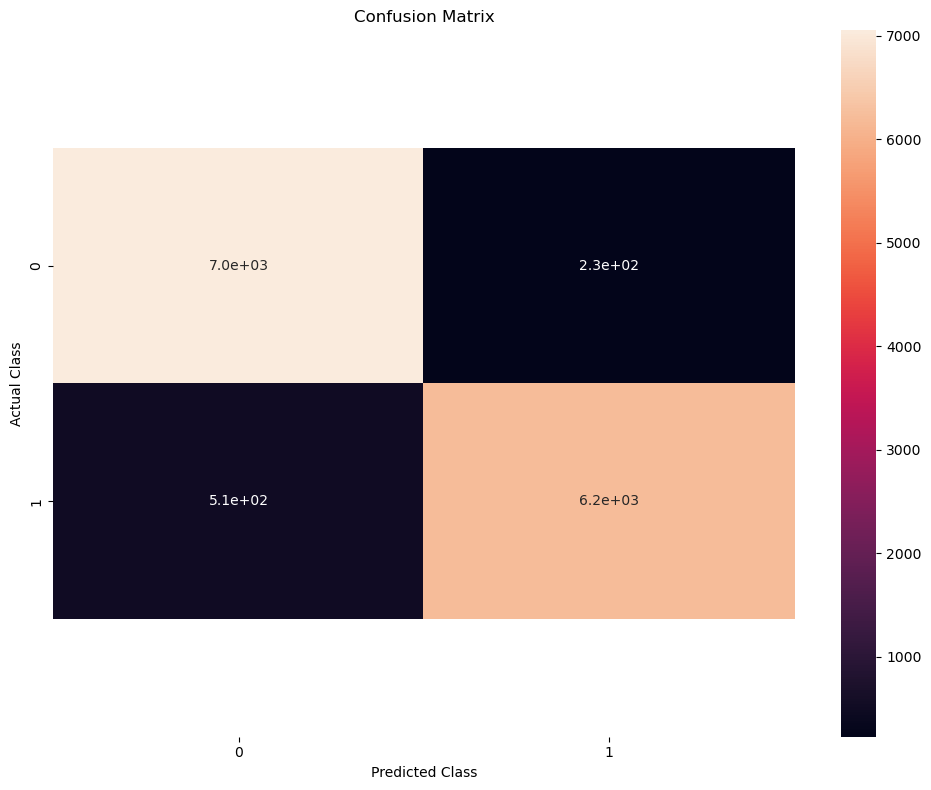

In [21]:
utils.plot_confusion_matrix(test_df['y_actual'], test_df['y_pred'])

#### The Classification Report

../modules/utils.py:281: MatplotlibDeprecationWarning:


The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.

../modules/utils.py:282: MatplotlibDeprecationWarning:


The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.

../modules/utils.py:284: MatplotlibDeprecationWarning:


The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.

../modules/utils.py:285: MatplotlibDeprecationWarning:


The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.



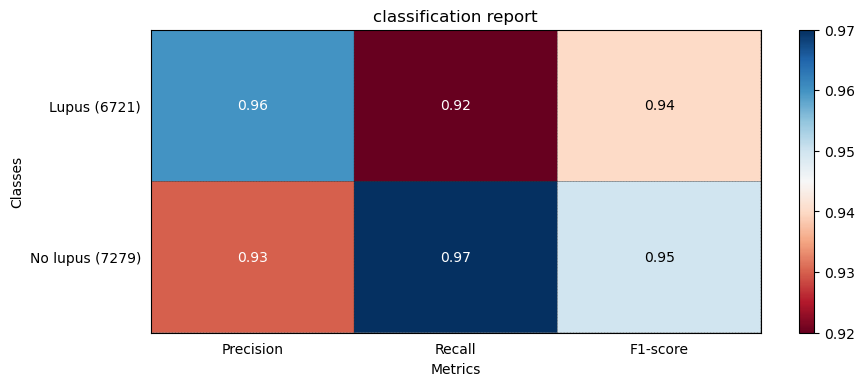

In [22]:
utils.plot_classification_report(test_df['y_actual'], test_df['y_pred'])